Steane code decoding with noise
===========================

1. Set up logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474

2. Set up the ancilla

3. The error correction circuit is not set up because it introduces to much noise.

4. Set up the decoding circuit and measure the error.

The program runs through different scenarios to assess the noise introduced by the encoding, detection and decoding separately.

Import the necessary function modules, including the SteaneCodeLogicalQubit class.  The methods of this class are called in this notebook.

In [1]:
from qiskit import(
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile

from circuits import SteaneCodeLogicalQubit

import matplotlib.pyplot as plt
import numpy as np

from helper_functions import (
    count_valid_output_strings,
    find_individual_ancilla_values,
    find_ancilla_values,
    find_parity,
    get_noise,
    mean_of_list,
    calculate_standard_error,
    get_parity_check_matrix,
    get_codewords
)

Define constants so the process flow can be controlled from one place:

In [2]:
SINGLE_GATE_SET = ['id', 'ry', 'rx']
TWO_GATE_SET = ['rxx']
BASIS_GATE_SET = SINGLE_GATE_SET + TWO_GATE_SET

ERROR_REDUCTION = 1

NOISE = True                                              #Test with noise
SHOTS = 10000                                             #Number of shots to run    
MEASURE_NOISE = 0.0046 * ERROR_REDUCTION                  #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.000366 * ERROR_REDUCTION     #Single gate noise   
TWO_GATE_DEPOLARISING = 0.022 * ERROR_REDUCTION 
ITERATIONS = 25

SIMULATOR = Aer.get_backend('qasm_simulator')

# Can't have both PS and simple true
PS = False  
SIMPLE = True
TITLE = 'Error rate by stage measured with '
if PS:
    if SIMPLE:
        raise ValueError('Not able to run with both PS and SIMPLE true')
    else:
        title = TITLE + 'PS'
elif SIMPLE:
    title = TITLE + 'simple decoding'               
else:
    title = TITLE + 'standard decoding'

Specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = get_parity_check_matrix()
print(parity_check_matrix)

['0001111', '0110011', '1010101']


The allowed codewords for the zero logical from Nielsen and Chuang is stored in a list.  Note, the order of qubits in the list is reversed compared to the normal output of Qiskit.

In [4]:
codewords = get_codewords()
print(codewords)

['0000000', '1010101', '0110011', '1100110', '0001111', '1011010', '0111100', '1101001']


Define the initial codewords

In [5]:
initial_codeword = '0000000'

Error decoding
---------------------

Different scenarios are set up to measure the noise of each component.

The initial bit string is '0000000'.  After encoding the valid bit strings are as shown in the codewords list above.  Finally, after decoding, the valid bit string is again '0000000'.

For the simple decoding circuit after decoding the validity of the output string is based solely on bit two.

In [6]:
#set up scenarios ready to loop through
scenarios = {
        'measurement only':{
            'Encoding' : False, 'Ancilla' : False, 'Decoding' : False, 'Use_Initial_codeword' : True
               },
        'encoding':{
            'Encoding' : True, 'Ancilla' : False, 'Decoding' : False, 'Use_Initial_codeword' : False
               },
        'detection':{
            'Encoding' : True, 'Ancilla' : True, 'Decoding' : False, 'Use_Initial_codeword' : False
                },
        'decoding':{
            'Encoding' : True, 'Ancilla' : True, 'Decoding' : True, 'Use_Initial_codeword' : True
                }
            }

In [7]:
#graph indices
labels = []
last_stage_error = []
this_stage_error = []
last_stage_standard_error = []
this_stage_standard_error =[]

# used after decoding
print(f'An error reduction factor of {ERROR_REDUCTION:.4f} is used.')
print(f'Running with {ITERATIONS} iterations and {SHOTS} shots')
print()

mean_last_error_rate = 0
last_standard_error = 0
mean_last_count_invalid = 0
first_loop = True
for cases, parameters in scenarios.items():
    encoding = parameters.get('Encoding')
    ancilla = parameters.get('Ancilla')
    decoding = parameters.get('Decoding')
    use_initial_codeword = parameters.get('Use_Initial_codeword')
    count_valid_list = []
    count_invalid_list = []
    error_rate_list = []
    for iteration in range(ITERATIONS):  
        qubit = SteaneCodeLogicalQubit(1, parity_check_matrix, codewords, extend_ancilla = False)
        if encoding:
            qubit.set_up_logical_zero()
            qubit.barrier()
        if ancilla:
            qubit.set_up_ancilla()
            qubit.barrier()
        if decoding:
            qubit.decode(simple = SIMPLE)
        if NOISE:
            noise_model = get_noise(MEASURE_NOISE, SINGLE_GATE_DEPOLARISING, 
                                    TWO_GATE_DEPOLARISING, SINGLE_GATE_SET, TWO_GATE_SET)
        qubit.barrier()
        qubit.logical_measure_data()
        qubit.logical_measure_ancilla()
        qt = transpile(qubit, basis_gates = BASIS_GATE_SET)
        if NOISE:
            result = execute(qt, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
        else:
            result = execute(qt, SIMULATOR, shots = SHOTS).result()
        counts = result.get_counts(qt)
        if SIMPLE:
            valid_codewords = ['0']
        else:
            if use_initial_codeword:
                valid_codewords = initial_codeword
            else:
                valid_codewords = codewords
        if SIMPLE and decoding:
            #validity based on bit 2 only after simple decoding circuit
            count_valid, count_invalid, _ = count_valid_output_strings(counts, 
                                                                       valid_codewords, 
                                                                       data_location = 2, 
                                                                       post_selection = PS,
                                                                       simple = False,
                                                                       single = True,
                                                                       single_bit = 2)
            
        else:
            count_valid, count_invalid, _ = count_valid_output_strings(counts, 
                                                                       valid_codewords, 
                                                                       data_location = 2, 
                                                                       post_selection = PS,
                                                                       simple = SIMPLE,
                                                                       )
        error_rate = count_invalid / SHOTS
        count_valid_list.append(count_valid)
        count_invalid_list.append(count_invalid)
        error_rate_list.append(error_rate)
    print(f'For the scenario with {cases} the results are:' )
    labels.append(cases)
    mean_count_valid = mean_of_list(count_valid_list)
    mean_count_invalid = mean_of_list(count_invalid_list)
    mean_error_rate = mean_of_list(error_rate_list)  
    standard_deviation, standard_error = calculate_standard_error(error_rate_list)
    print(f'The mean cumulative error rate is {mean_error_rate:.6f}')
    print(f'  with a standard error of {standard_error:.6f}')
    print(f'On average there were {mean_count_invalid:.3f} invalid bit strings after this stage.')
    print(f'On average there were {mean_count_valid:.3f} valid bit strings after this stage.')
    if first_loop:
        first_loop = False
    else:
        mean_stage_count_invalid = mean_count_invalid - mean_last_count_invalid
        print(f'On average this stage introduced {mean_stage_count_invalid:.1f} new errors')     
    mean_stage_error_rate = (mean_error_rate - mean_last_error_rate)
    print(f'On average the error rate introduced by this stage is {mean_stage_error_rate:.4f}')
    print(f'The prior error rate is {mean_last_error_rate:.6f}')
    print(f'  with a standard error of {last_standard_error:.6f}')
          
    this_stage_error.append(mean_error_rate)
    this_stage_standard_error.append(standard_error)
    last_stage_error.append(mean_last_error_rate)
    last_stage_standard_error.append(last_standard_error)
          
    mean_last_error_rate = mean_error_rate
    last_standard_error = standard_error
    mean_last_count_invalid = mean_count_invalid
    print()

An error reduction factor of 1.0000 is used.
Running with 25 iterations and 10000 shots

For the scenario with measurement only the results are:
The mean cumulative error rate is 0.013936
  with a standard error of 0.000180
On average there were 139.360 invalid bit strings after this stage.
On average there were 9860.640 valid bit strings after this stage.
On average the error rate introduced by this stage is 0.0139
The prior error rate is 0.000000
  with a standard error of 0.000000

For the scenario with encoding the results are:
The mean cumulative error rate is 0.112424
  with a standard error of 0.000662
On average there were 1124.240 invalid bit strings after this stage.
On average there were 8875.760 valid bit strings after this stage.
On average this stage introduced 984.9 new errors
On average the error rate introduced by this stage is 0.0985
The prior error rate is 0.013936
  with a standard error of 0.000180

For the scenario with detection the results are:
The mean cumulati

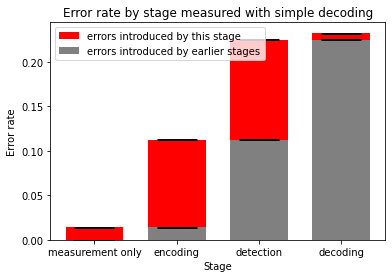

In [8]:
import matplotlib.pyplot as plt
YMIN = 0
YMAX = 1.0
YTICK = 0.2
WIDTH = 0.7
BAR_WIDTH = 10
CAPSIZE = 20

fig, ax = plt.subplots()

ax.bar(labels, this_stage_error, WIDTH, label = 'errors introduced by this stage', color = "red")
ax.bar(labels, last_stage_error, WIDTH, label = 'errors introduced by earlier stages', color = "grey")
plt.errorbar(labels, this_stage_error, yerr = this_stage_standard_error, 
             color = 'black', fmt = 'none', elinewidth = BAR_WIDTH, capsize = CAPSIZE )
plt.errorbar(labels, last_stage_error, yerr = last_stage_standard_error, 
             color = 'black', fmt = 'none', elinewidth = BAR_WIDTH, capsize = CAPSIZE)

ax.set_xlabel('Stage')
ax.set_ylabel('Error rate')
ax.set_title(title)
ax.legend()

fname = './graphs/' + title
plt.savefig(fname)

Draw circuit

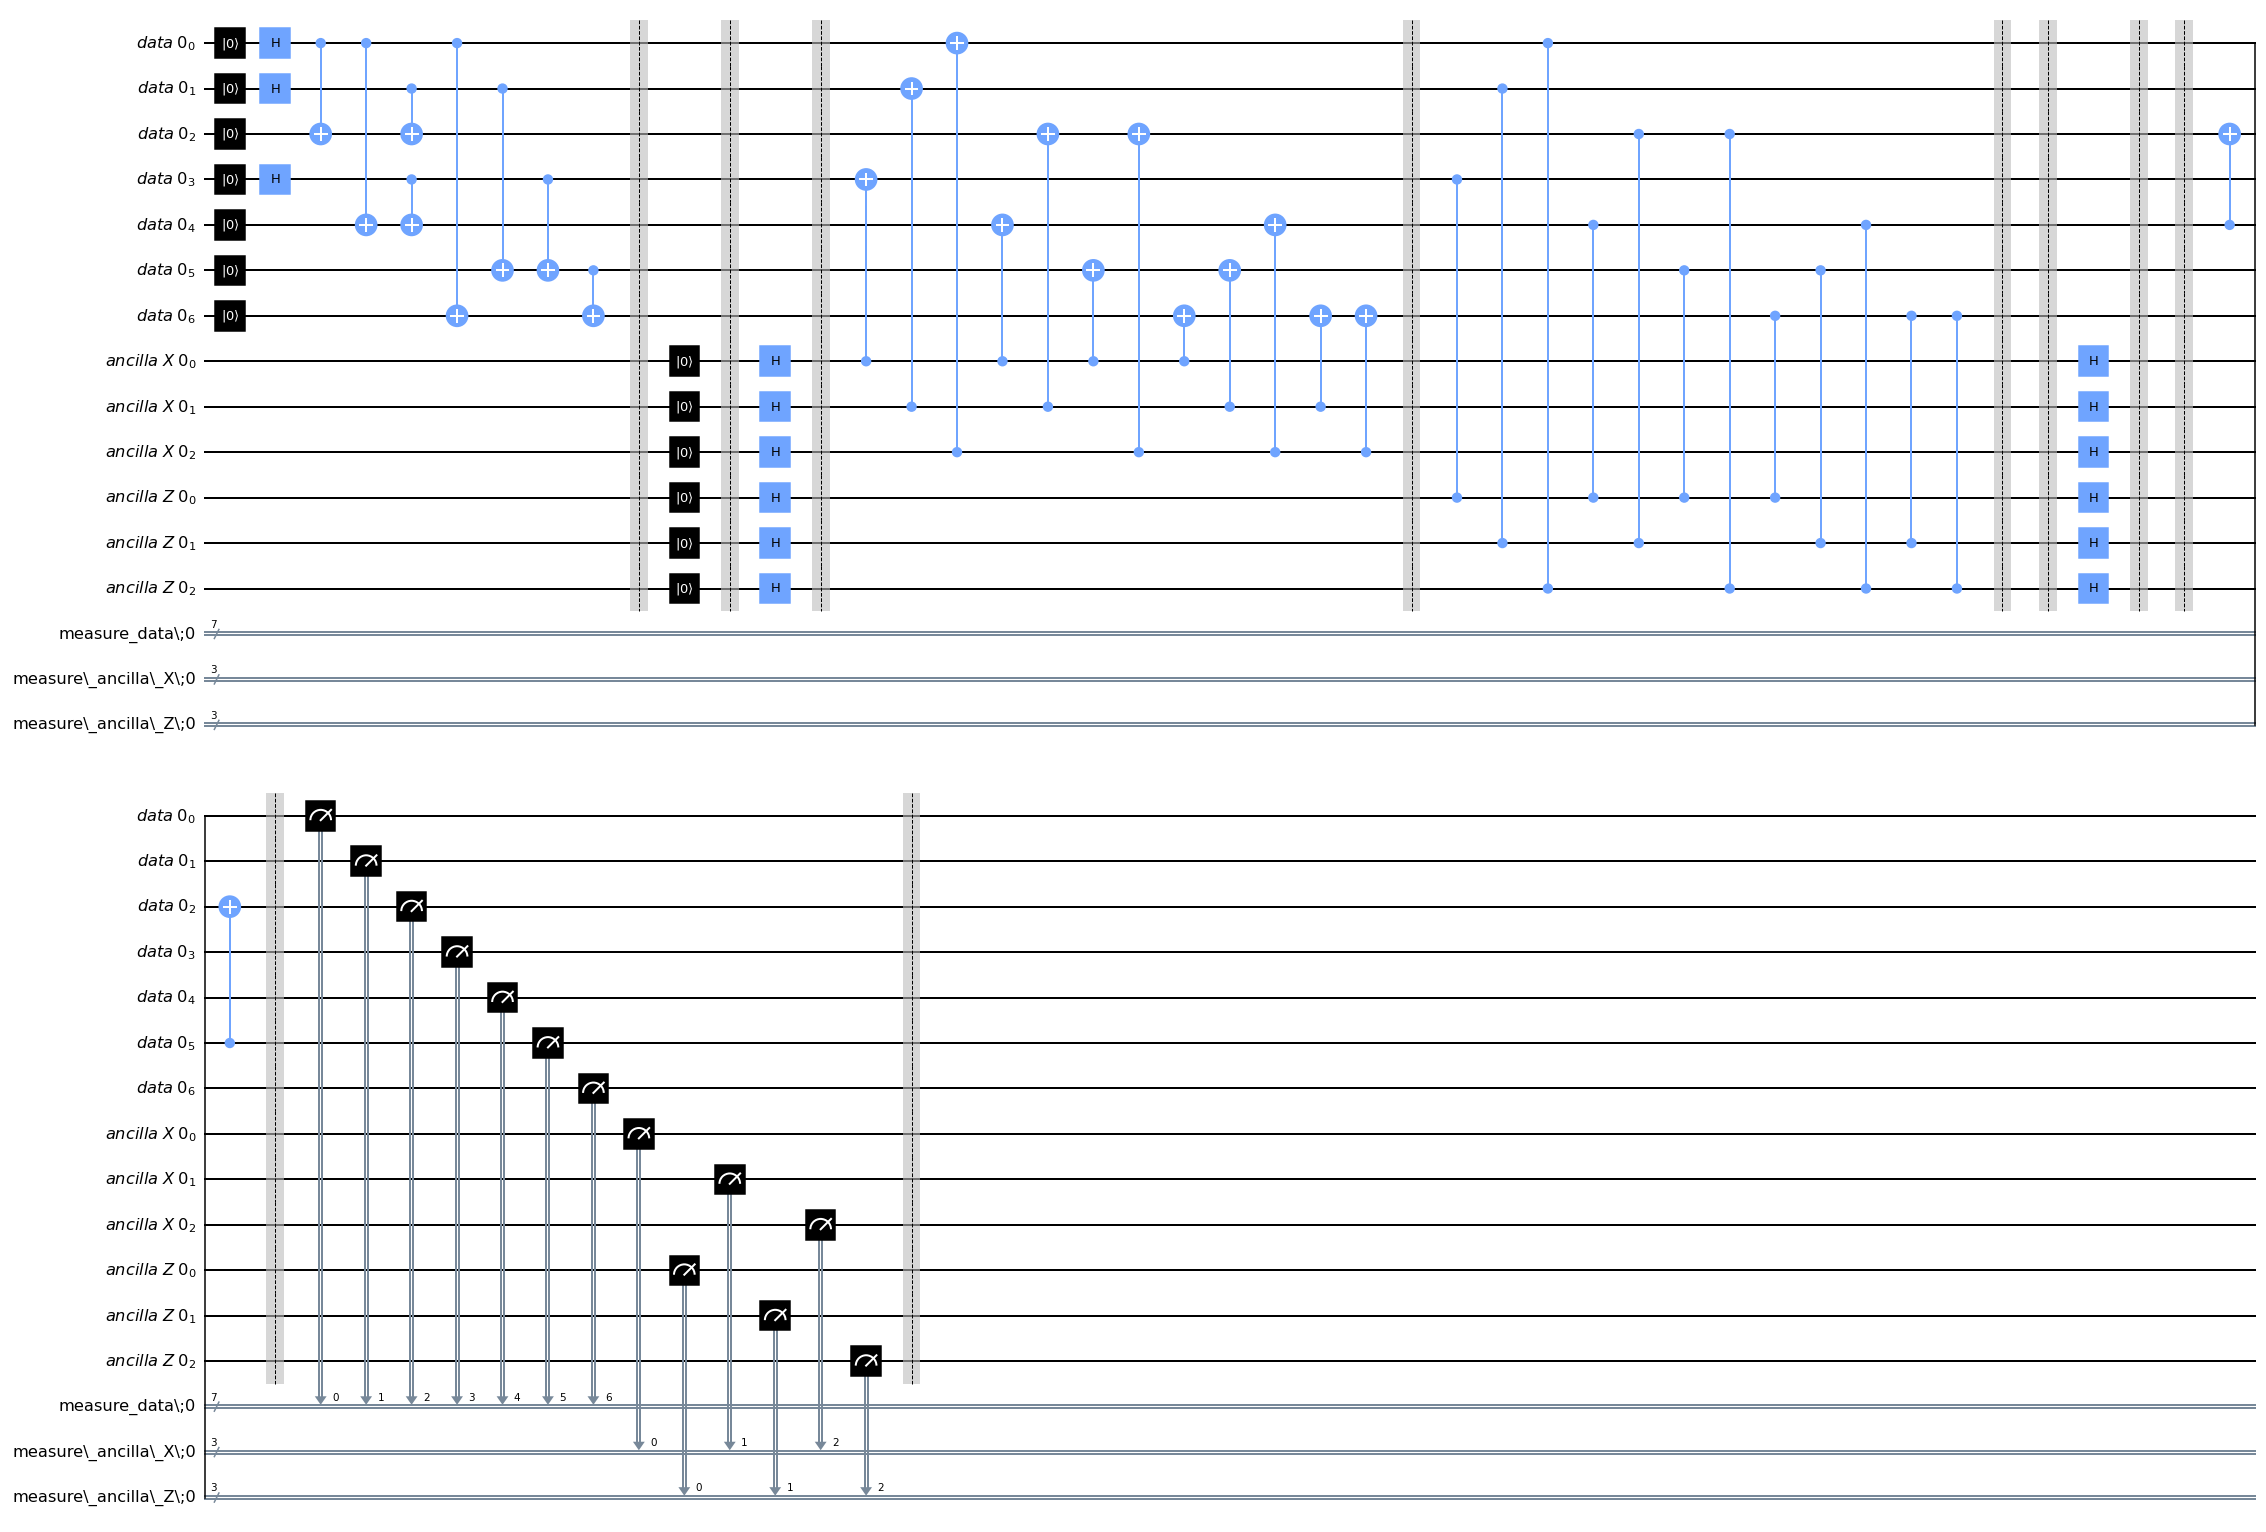

In [9]:
qubit.draw(output = 'mpl', filename = './circuits/Steane_code_decoding_circuit.jpg', fold = 45)

Draw transpiled circuit

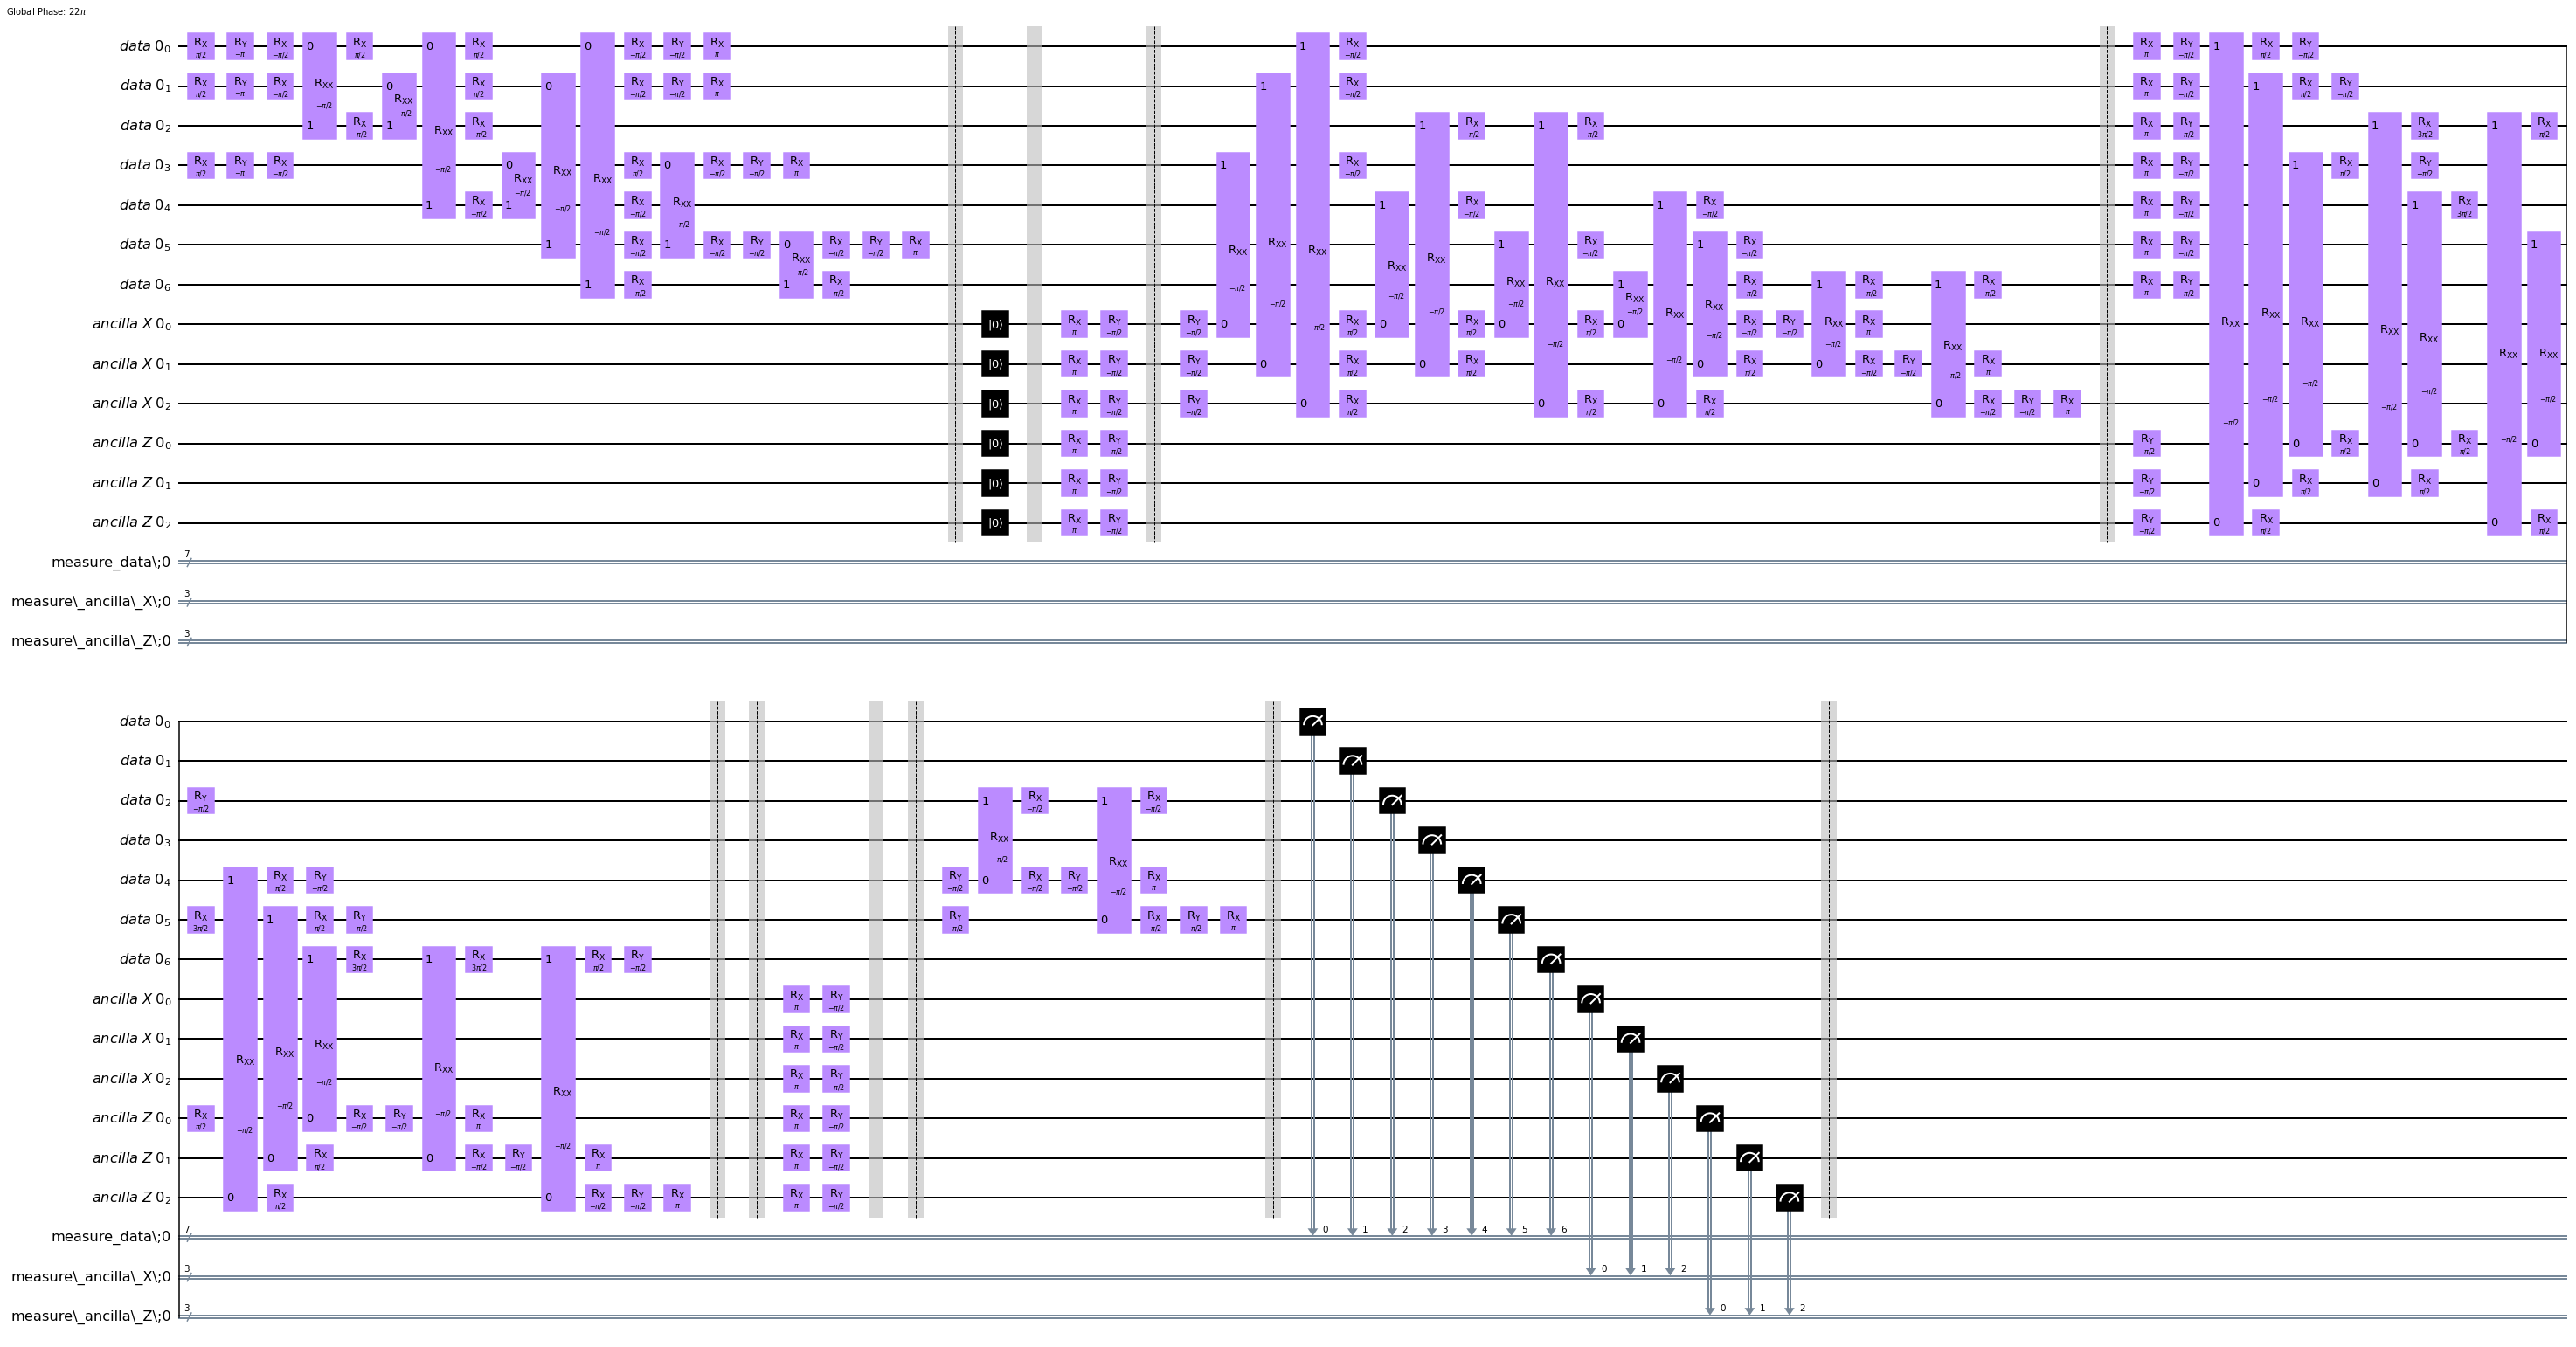

In [10]:
qt.draw(output = 'mpl', filename = './circuits/Steane_code_error_decoding_circuit_transpiled.jpg', fold = 60)